In [2]:
import serial,time
import numpy as np
import matplotlib.pyplot as plt
import openpyxl
import os
import pandas as pd

In [ ]:
arduino = serial.Serial('COM3',9600,timeout=0.01)# Se debe indicar el puerto serial y la velocidad de transmision 

time.sleep(2)

numero_datos = 1000 # esto corresponde al numero de datos que se va adquirir, se puede modificar pero 1000 es un buen numero 
EMG = np.ndarray((0),dtype=int) # aquí se almacenará la señal 

# mientras el arreglo no tenga los datos que requiero los solicito
while EMG.shape[0] < numero_datos: 
    
    # esto lee lo que haya en el buffer
    datos = arduino.readlines(arduino.inWaiting())
    
    datos_por_leer = len(datos)
    
  
    # Si hay mas datos de los que quiero leer
    # solo me quedo con la cantidad que me interesa
    if len(datos) > numero_datos:
        datos = datos[0:numero_datos]
        # creo un arreglo de ceros para leer estos valores
        valores_leidos = np.zeros(numero_datos,dtype = int)
    else:
        # creo un arreglo de ceros para leer estos valores
        valores_leidos = np.zeros(datos_por_leer,dtype = int)

    
    posicion = 0
    #se convierten los datos a valores numericos de voltaje. 
    for dato in datos:
        # voy a tratar de convertir los datos
        try:
            # elimino los saltos de linea y caracter de retorno y convierto a entero
            valores_leidos[posicion] = int(dato.decode().strip())
        except:
            # si no puedo convertir completo la muestra con el anterior
             valores_leidos[posicion] = 0  # alternativa
            #valores_leidos[posicion] = valores_leidos[posicion-1]
        posicion = posicion + 1
    # agrego los datos leidos al arreglo
    EMG = np.append(EMG,valores_leidos)
    # Introduzco un delay para que se llene de nuevo el buffer
    time.sleep(2)

# como la ultima lectura puede tener mas datos de los que necesito descarto las muestras restantes
EMG = EMG[0:numero_datos]

# ya con los datos leidos podemos graficar y guardar
ruta_actual = os.path.dirname(os.path.abspath(__file__))
nombre_archivo = "datos_ecg.xlsx"
ruta = os.path.join(ruta_actual, nombre_archivo)
# Crear un nuevo libro de trabajo de Excel
libro_trabajo = openpyxl.Workbook()

# Seleccionar la hoja activa
hoja = libro_trabajo.active

# Escribir la señal en la hoja de Excel
for i, valor in enumerate(EMG, start=1):
    hoja.cell(row=i, column=1).value = valor

# Guardar el archivo Excel
libro_trabajo.save(ruta)
plt.plot(EMG)
plt.show()
arduino.close()  # Cerrar puerto serial, siempre debe cerrarse

## Filtrado de la señal
### Para el caso de la electrocardiografía, la señal se captó con un poco más de precisión, por lo que solamente hubo necesidad de hacer un filtrado, en el cual se eliminaron los valores de amplitud de 310, referentes a las fuentes de interferencia [300-350].

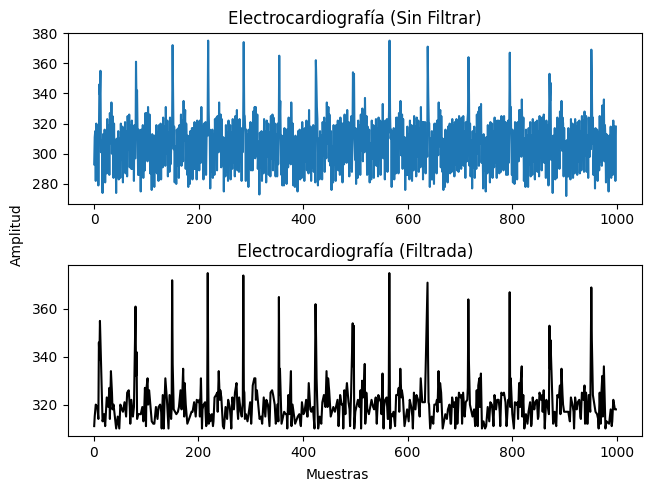

In [14]:
df = pd.read_excel('datos_ecg.xlsx')
df_filtrada=df[(df >= 310).all(axis=1)]
# Crear la figura y los subgráficos
fig, axs = plt.subplots(2,1)
# Graficar en el primer subgráfico
axs[0].plot(df)
axs[0].set_title('Electrocardiografía (Sin Filtrar)')
# Graficar en el segundo subgráfico
axs[1].plot(df_filtrada,color='k')
axs[1].set_title('Electrocardiografía (Filtrada)')
# Añadir etiquetas al eje x y al eje y en toda la figura
fig.text(0.5, 0, 'Muestras', ha='center', va='center')
fig.text(0, 0.5, 'Amplitud', ha='center', va='center', rotation='vertical')
# Ajustar los espacios entre subgráficos
plt.tight_layout()
# Mostrar la figura
plt.show()